In [1]:
import torch
import torchvision

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

use_cuda = torch.cuda.is_available()
random_seed = 1
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(random_seed)
device

device(type='cuda')

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
example_data.shape

torch.Size([1000, 1, 28, 28])

/home/mma/anaconda3/envs/PyTorch/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


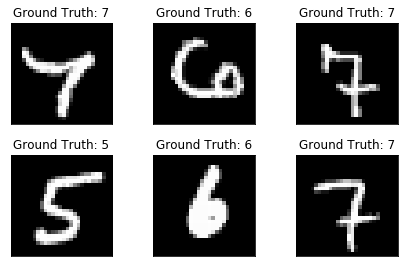

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig.show()

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [10]:
network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [11]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [12]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'results/model.pth')
      torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [13]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [14]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/home/mma/anaconda3/envs/PyTorch/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/mma/anaconda3/envs/PyTorch/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3004, Accuracy: 751/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.278280
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.279660
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.263015
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.256703
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.301101
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.189042
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.182183
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.072716
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.030585
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.080526
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.933958
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.736156
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.913199
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.750768
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.448583
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.501194
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.318699
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.455112
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.298752
Train Epoch: 1 [12160/6

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.368547
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.200150
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.391010
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.588992
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.672676
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.417527
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.419727
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.357625
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.170214
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.281838
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.249181
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.397371
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.304660
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.325881
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.254249
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.355608
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.478962
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.412761
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.569863
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.610785


/home/mma/anaconda3/envs/PyTorch/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


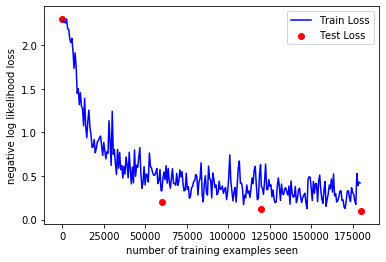

In [15]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig.show()

In [16]:
with torch.no_grad():
  output = network(example_data.to(device))

/home/mma/anaconda3/envs/PyTorch/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [17]:
output.shape

torch.Size([1000, 10])

/home/mma/anaconda3/envs/PyTorch/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


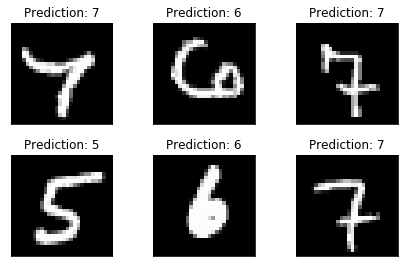

In [18]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig.show()

In [19]:
continued_network = Net().to(device)
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [20]:
network_state_dict = torch.load("results/model.pth")
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load("results/optimizer.pth")
continued_optimizer.load_state_dict(optimizer_state_dict)

In [21]:
for i in range(4,13):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

/home/mma/anaconda3/envs/PyTorch/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.228455
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.555774
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.461280
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.234690
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.255643
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.284248
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.233772
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.299899
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.317656
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.291886
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.239536
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.368546
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.246713
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.232912
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.220255
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.211263
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.568910
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.315270
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.243402
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.426373
Train Epoch: 4 [12800/60000 (

Train Epoch: 5 [45440/60000 (76%)]	Loss: 0.095498
Train Epoch: 5 [46080/60000 (77%)]	Loss: 0.139356
Train Epoch: 5 [46720/60000 (78%)]	Loss: 0.302851
Train Epoch: 5 [47360/60000 (79%)]	Loss: 0.213214
Train Epoch: 5 [48000/60000 (80%)]	Loss: 0.310906
Train Epoch: 5 [48640/60000 (81%)]	Loss: 0.165632
Train Epoch: 5 [49280/60000 (82%)]	Loss: 0.221273
Train Epoch: 5 [49920/60000 (83%)]	Loss: 0.205886
Train Epoch: 5 [50560/60000 (84%)]	Loss: 0.176472
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.058428
Train Epoch: 5 [51840/60000 (86%)]	Loss: 0.304673
Train Epoch: 5 [52480/60000 (87%)]	Loss: 0.241933
Train Epoch: 5 [53120/60000 (88%)]	Loss: 0.415596
Train Epoch: 5 [53760/60000 (90%)]	Loss: 0.134688
Train Epoch: 5 [54400/60000 (91%)]	Loss: 0.250417
Train Epoch: 5 [55040/60000 (92%)]	Loss: 0.154696
Train Epoch: 5 [55680/60000 (93%)]	Loss: 0.235677
Train Epoch: 5 [56320/60000 (94%)]	Loss: 0.154486
Train Epoch: 5 [56960/60000 (95%)]	Loss: 0.276735
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.292083


Train Epoch: 7 [29440/60000 (49%)]	Loss: 0.185782
Train Epoch: 7 [30080/60000 (50%)]	Loss: 0.195985
Train Epoch: 7 [30720/60000 (51%)]	Loss: 0.102441
Train Epoch: 7 [31360/60000 (52%)]	Loss: 0.221609
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.278481
Train Epoch: 7 [32640/60000 (54%)]	Loss: 0.324748
Train Epoch: 7 [33280/60000 (55%)]	Loss: 0.291925
Train Epoch: 7 [33920/60000 (57%)]	Loss: 0.366118
Train Epoch: 7 [34560/60000 (58%)]	Loss: 0.200572
Train Epoch: 7 [35200/60000 (59%)]	Loss: 0.235519
Train Epoch: 7 [35840/60000 (60%)]	Loss: 0.169521
Train Epoch: 7 [36480/60000 (61%)]	Loss: 0.287195
Train Epoch: 7 [37120/60000 (62%)]	Loss: 0.150113
Train Epoch: 7 [37760/60000 (63%)]	Loss: 0.183914
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.105617
Train Epoch: 7 [39040/60000 (65%)]	Loss: 0.266206
Train Epoch: 7 [39680/60000 (66%)]	Loss: 0.251133
Train Epoch: 7 [40320/60000 (67%)]	Loss: 0.102708
Train Epoch: 7 [40960/60000 (68%)]	Loss: 0.148151
Train Epoch: 7 [41600/60000 (69%)]	Loss: 0.147430


Train Epoch: 9 [14080/60000 (23%)]	Loss: 0.228728
Train Epoch: 9 [14720/60000 (25%)]	Loss: 0.246542
Train Epoch: 9 [15360/60000 (26%)]	Loss: 0.202019
Train Epoch: 9 [16000/60000 (27%)]	Loss: 0.124529
Train Epoch: 9 [16640/60000 (28%)]	Loss: 0.077475
Train Epoch: 9 [17280/60000 (29%)]	Loss: 0.314730
Train Epoch: 9 [17920/60000 (30%)]	Loss: 0.228762
Train Epoch: 9 [18560/60000 (31%)]	Loss: 0.125869
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.149029
Train Epoch: 9 [19840/60000 (33%)]	Loss: 0.267015
Train Epoch: 9 [20480/60000 (34%)]	Loss: 0.134143
Train Epoch: 9 [21120/60000 (35%)]	Loss: 0.228600
Train Epoch: 9 [21760/60000 (36%)]	Loss: 0.351166
Train Epoch: 9 [22400/60000 (37%)]	Loss: 0.278466
Train Epoch: 9 [23040/60000 (38%)]	Loss: 0.045942
Train Epoch: 9 [23680/60000 (39%)]	Loss: 0.207806
Train Epoch: 9 [24320/60000 (41%)]	Loss: 0.152437
Train Epoch: 9 [24960/60000 (42%)]	Loss: 0.108370
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.146705
Train Epoch: 9 [26240/60000 (44%)]	Loss: 0.075517


Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.095354
Train Epoch: 10 [58240/60000 (97%)]	Loss: 0.224445
Train Epoch: 10 [58880/60000 (98%)]	Loss: 0.159041
Train Epoch: 10 [59520/60000 (99%)]	Loss: 0.094115

Test set: Avg. loss: 0.0501, Accuracy: 9837/10000 (98%)

Train Epoch: 11 [0/60000 (0%)]	Loss: 0.201582
Train Epoch: 11 [640/60000 (1%)]	Loss: 0.123509
Train Epoch: 11 [1280/60000 (2%)]	Loss: 0.222593
Train Epoch: 11 [1920/60000 (3%)]	Loss: 0.110652
Train Epoch: 11 [2560/60000 (4%)]	Loss: 0.161806
Train Epoch: 11 [3200/60000 (5%)]	Loss: 0.112539
Train Epoch: 11 [3840/60000 (6%)]	Loss: 0.035190
Train Epoch: 11 [4480/60000 (7%)]	Loss: 0.172170
Train Epoch: 11 [5120/60000 (9%)]	Loss: 0.069389
Train Epoch: 11 [5760/60000 (10%)]	Loss: 0.478651
Train Epoch: 11 [6400/60000 (11%)]	Loss: 0.083949
Train Epoch: 11 [7040/60000 (12%)]	Loss: 0.193336
Train Epoch: 11 [7680/60000 (13%)]	Loss: 0.338412
Train Epoch: 11 [8320/60000 (14%)]	Loss: 0.176157
Train Epoch: 11 [8960/60000 (15%)]	Loss: 0.129622
T

Train Epoch: 12 [39680/60000 (66%)]	Loss: 0.142624
Train Epoch: 12 [40320/60000 (67%)]	Loss: 0.100589
Train Epoch: 12 [40960/60000 (68%)]	Loss: 0.163526
Train Epoch: 12 [41600/60000 (69%)]	Loss: 0.110663
Train Epoch: 12 [42240/60000 (70%)]	Loss: 0.140171
Train Epoch: 12 [42880/60000 (71%)]	Loss: 0.128670
Train Epoch: 12 [43520/60000 (72%)]	Loss: 0.159893
Train Epoch: 12 [44160/60000 (74%)]	Loss: 0.131272
Train Epoch: 12 [44800/60000 (75%)]	Loss: 0.250522
Train Epoch: 12 [45440/60000 (76%)]	Loss: 0.143948
Train Epoch: 12 [46080/60000 (77%)]	Loss: 0.176625
Train Epoch: 12 [46720/60000 (78%)]	Loss: 0.049196
Train Epoch: 12 [47360/60000 (79%)]	Loss: 0.198216
Train Epoch: 12 [48000/60000 (80%)]	Loss: 0.326414
Train Epoch: 12 [48640/60000 (81%)]	Loss: 0.239237
Train Epoch: 12 [49280/60000 (82%)]	Loss: 0.368728
Train Epoch: 12 [49920/60000 (83%)]	Loss: 0.150059
Train Epoch: 12 [50560/60000 (84%)]	Loss: 0.139382
Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.215516
Train Epoch: 12 [51840/60000 (8

/home/mma/anaconda3/envs/PyTorch/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


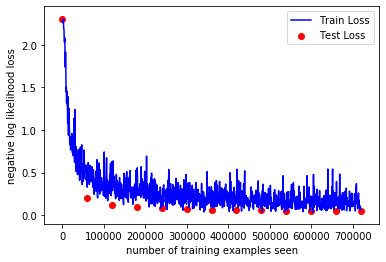

In [22]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig.show()

In [73]:
import pandas as pd


In [74]:
data = pd.read_csv('data/test.csv')

In [75]:
data.tail()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
output = []
# output = torch.Tensor(output).to(device)
for i in range(1, 29):
    with torch.no_grad():
        output.append(network(torch.tensor(data[(i-1)*1000:i*1000].values.reshape((1000, 1, 28, 28))).to(device=device,  dtype=torch.float)))

/home/mma/anaconda3/envs/PyTorch/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [78]:
pred = []
for i in range(28):
    for j in range(1000):
        pred.append(output[i][j].data.argmax().item())

In [79]:
output=pd.DataFrame({'ImageId':data.index+1,'Label':pred})

In [80]:
output.to_csv('submission1.csv', index=False)